In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Function Definitions

In [26]:
def cutoff_index(arr,cutoff):
    max_cutoff = len(arr)
    if np.all(np.invert(np.isfinite(arr))):
        return np.nan
    arr = arr[np.isfinite(arr)]
    for i in range(len(arr)):
        if np.all(arr[i:]>cutoff):
            return i
    return max_cutoff-1

def compute_threshold_array(full_df,cutoff):
    nL_list = np.sort(np.unique(full_df.nL.values))
    nL_working = [] ## For some values of nL, the p_values are all NAN because n>L. This list excludes those values
    cutoff_list = []
    for nL in nL_list:
        subset_df = full_df[full_df.nL == nL]
        arr = subset_df.p_1.values
        tau_list = subset_df.tau.values
        if not np.any(np.isnan(arr)):
            nL_working.append(nL)
            cutoff_list.append(tau_list[cutoff_index(arr,cutoff=cutoff)])

    return nL_working,cutoff_list



# Phase Change Behaviour

### Identifying the parameters used (Fst, n and L)

In [3]:
N=1000
path = "../data/eigen_analysis/pop_split/"
folders = os.listdir(path)
tau_list = []

for i,folder in enumerate(folders):
    tau = float(folder.split("=")[1])
    tau_list.append(tau)
folders = np.array(folders)

tau_order = np.argsort(tau_list)
tau_ordered = np.sort(tau_list)

n_list = np.linspace(10,990,50)
L_list = np.geomspace(50,8000,20).astype(int)

### Combining data in different folders into a single dataframe

In [5]:
column_names =["tau"]+list(pd.read_csv(path+folders[0]+"/eigenvalues.csv",index_col=0).columns)
full_df = pd.DataFrame(columns = column_names)
unfinished_sims = [] ## Takes into account that for some tau values, the simulation was not successfully completed
for i,folder in enumerate(folders[tau_order]):
    try:
        temp_df = pd.read_csv(path+folder+"/eigenvalues.csv",index_col=0)
        tau = tau_ordered[i]
        temp_df['tau'] = [tau]*len(temp_df.index)
        temp_df = temp_df[["tau"]+list(temp_df.columns[:-1])]
        full_df = pd.concat([full_df,temp_df])
    except: 
        unfinished_sims.append(i)
        continue

finished_tau_ordered = np.zeros(len(tau_list))
finished_tau_ordered[unfinished_sims] = True
finished_tau_ordered = ~finished_tau_ordered.astype(bool)
finished_tau_ordered = tau_ordered[finished_tau_ordered]
full_df.replace(np.inf,16,inplace=True) ## very small p-values will have a -log10(p) set to 10
full_df["nL"] = full_df.n * full_df.L
full_df.to_csv("../data/full_data/pop_split.csv")

In [6]:
full_df

,tau,n,L,l_1,p_1,nL
0,0.00001,10.0,50.0,2.4403,0.73861,500.0
1,0.00001,10.0,65.0,2.1067,0.71828,650.0
2,0.00001,10.0,85.0,1.9223,0.72165,850.0
3,0.00001,10.0,111.0,1.8305,0.73791,1110.0
4,0.00001,10.0,145.0,1.9058,0.78575,1450.0
...,...,...,...,...,...,...
573,0.10000,990.0,2748.0,77.5582,16.00000,2720520.0
574,0.10000,990.0,3589.0,78.2226,16.00000,3553110.0
575,0.10000,990.0,4688.0,79.5796,16.00000,4641120.0
576,0.10000,990.0,6124.0,80.1951,16.00000,6062760.0


## phase transition in tau for different values of nL

Text(0, 0.5, '-log10(p)')

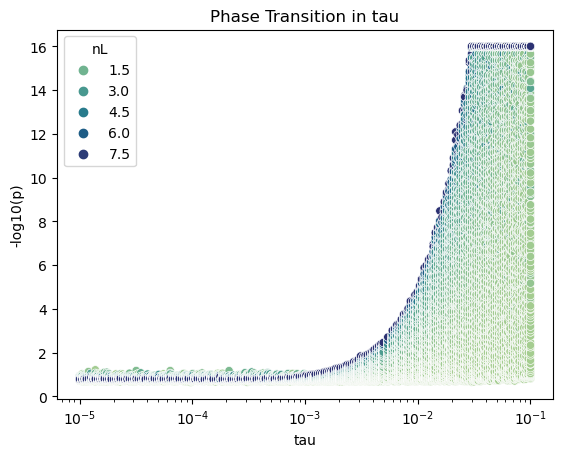

In [ ]:
sns.scatterplot(full_df,x = 'tau',y='p_1',hue='nL',palette = 'crest')
plt.title("Phase Transition in tau")
plt.xscale("log")
plt.xlabel("tau")
plt.ylabel("-log10(p)")

### Tau value beyond which structure starts being detected for a given combination of n and L

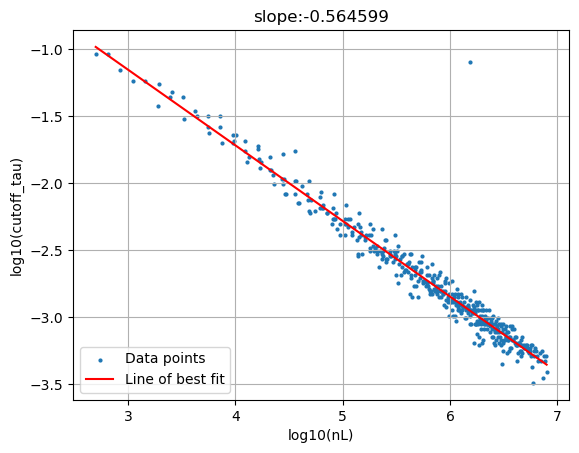

In [ ]:
cutoff = 0.8
nL_working,cutoff_list = compute_threshold_array(full_df,cutoff)
x_values = np.log10(nL_working)
y_values = np.log10(cutoff_list)

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values, s=4,label='Data points')
plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('log10(nL)')
plt.ylabel('log10(cutoff_tau)')
plt.title("slope:%2f"%coefficients[0])
plt.legend()
plt.grid(True)
plt.show()

# Eigenvectors

In [ ]:
def modify_eigenvector_df(folder):
    temp_df = pd.read_csv(path+folder+"/eigenvectors.csv",index_col=0)
    temp_df["nL"] = temp_df.n * temp_df.L
    temp_df["population"] = None
    nL_list = np.sort(np.unique(temp_df.nL.values))

    for nL in nL_list:
        temp_df_nL = temp_df[temp_df.nL == nL]
        n = int(temp_df_nL.iloc[0,0])
        first_half = temp_df_nL.iloc[:n,2].values
        if np.mean(first_half) <0:
            pop_labels = ["population_1"]*n + ["population_2"]*n
        else:
            pop_labels = ["population_2"]*n + ["population_1"]*n
        temp_df.iloc[temp_df_nL.index,-1] = pop_labels

    return temp_df
    
    

In [9]:
used_folders = folders[tau_order[np.linspace(5,199,9).astype(int)]]

/home/afselim/.conda/envs/main/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/afselim/.conda/envs/main/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


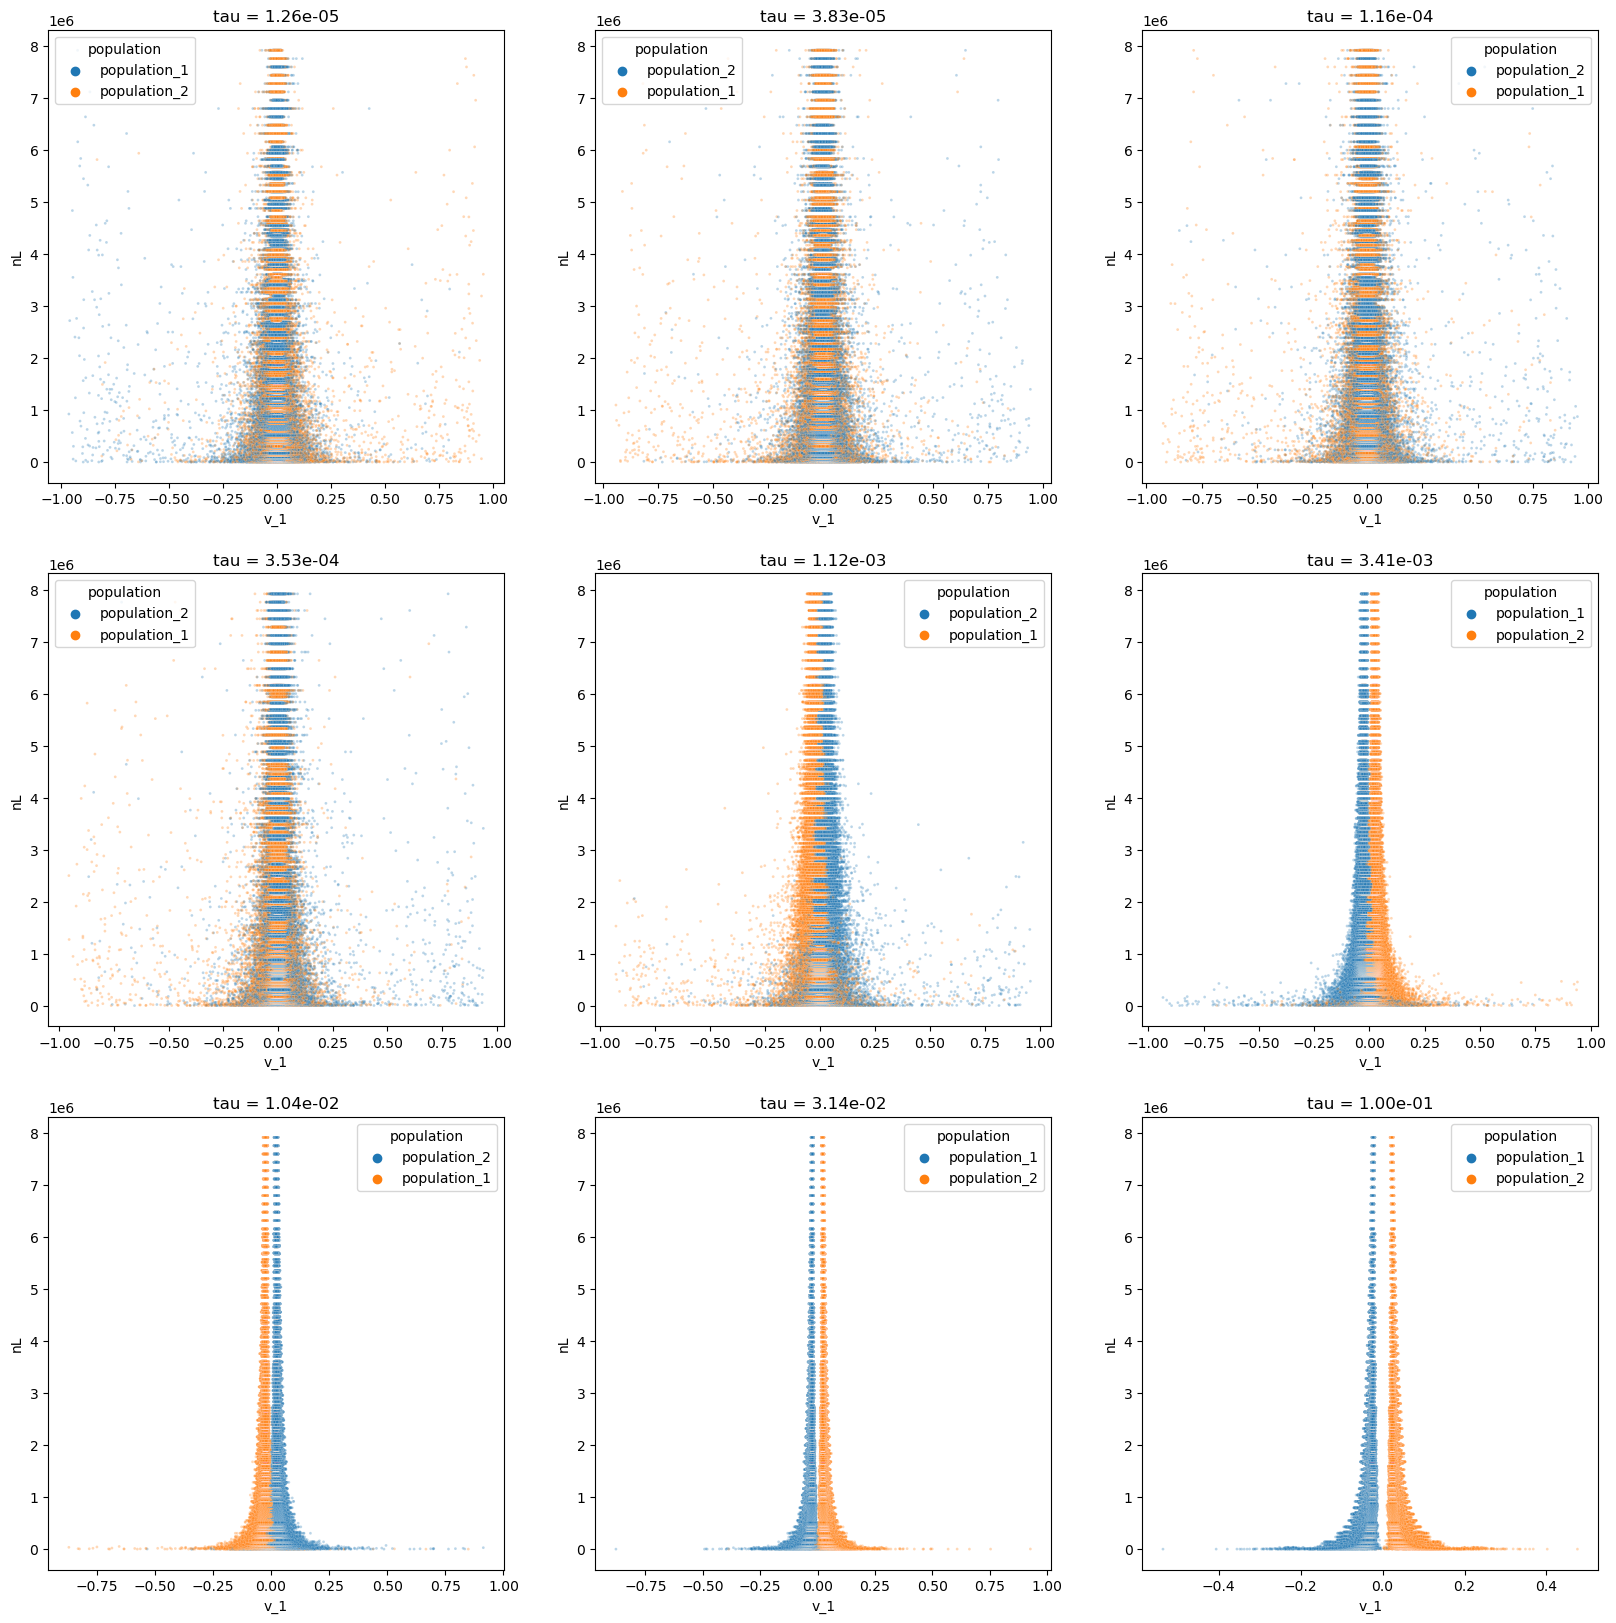

In [10]:
fig,ax = plt.subplots(3,3,figsize = (20,20))
for i,folder in enumerate(used_folders):
    temp_df = modify_eigenvector_df(folder)
    sns.scatterplot(temp_df,x = 'v_1',y='nL',hue = "population",alpha = 0.3,ax=ax[i//3,i%3],s=4)
    ax[i//3,i%3].set_title("tau = " + folder.split("=")[1])
    

### Inconsistency

In [18]:
nL_list = []
for n in n_list:
    for L in L_list:
        nL = n*L
        if nL not in nL_list:
            nL_list.append(nL)
nL_list = np.sort(np.array(nL_list))

In [19]:
inconsistency_df = pd.DataFrame(np.zeros((len(finished_tau_ordered),len(nL_list))), index = finished_tau_ordered, columns = nL_list )
def eig_inconsistency(v,Fst):
    n = len(v)
    half_n = int(n/2)
    u = [-Fst/2]*half_n + [Fst/2]*half_n
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    u_dot_v = np.dot(u,v)
    return np.arccos(u_dot_v/(norm_u*norm_v))

In [20]:
for i,folder in enumerate(folders):
    tau = tau_list[i]
    try:
        eigenvector_df = pd.read_csv(path+folder+"/eigenvectors.csv",index_col=0)
    except:
        continue
    for n in n_list:
        subset1 = eigenvector_df[eigenvector_df.n == n]
        for L in L_list:
            nL = n*L
            subset2 = subset1[subset1.L == L]
            v = subset2.v_1.values
            if len(v) == 0:
                continue
            if np.any(np.isnan(v)):
                continue
            pop1_centroid = np.mean(v[:int(n)])
            if pop1_centroid>0:
                v = -v
            
            inconsistency_df.loc[tau,nL]= eig_inconsistency(v,tau)
        
inconsistency_df = inconsistency_df.loc[:, ~(inconsistency_df == 0).any()]
inconsistency_df = inconsistency_df.loc[~(inconsistency_df == 0).any(axis=1)]

Text(50.722222222222214, 0.5, 'tau')

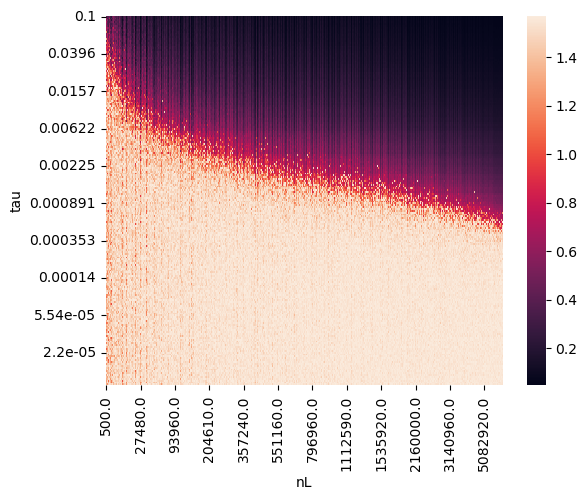

In [25]:
sns.heatmap(inconsistency_df[::-1],xticklabels = 50,yticklabels=20)
plt.xlabel("nL")
plt.ylabel("tau")

### The threshold for the eigenvectors

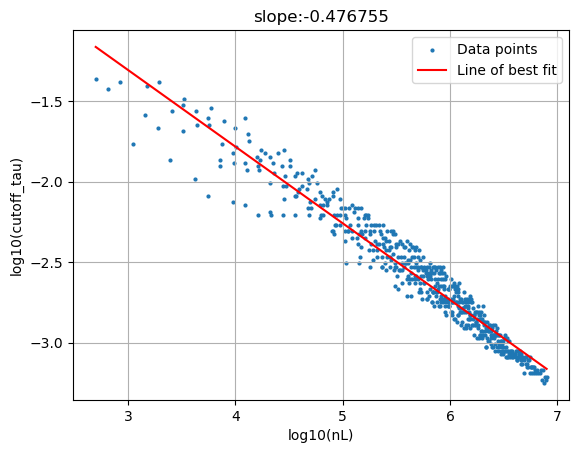

In [55]:
cutoff = 0.7 ## At what point does the angle start increasing
cutoff_list_eigenvectors = []
for nL in inconsistency_df.columns:
    v = inconsistency_df.loc[:,nL].values[::-1]
    cutoff_list_eigenvectors.append(finished_tau_ordered[::-1][cutoff_index(v,cutoff)])
    
x_values = np.log10(inconsistency_df.columns)
y_values = np.log10(cutoff_list_eigenvectors)

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values, s=4,label='Data points')
plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('log10(nL)')
plt.ylabel('log10(cutoff_tau)')
plt.title("slope:%2f"%coefficients[0])
plt.legend()
plt.grid(True)
plt.show()